In [1]:

import zipfile

# Path to the zip file in Colab
zip_path = '/content/Segmented_SAR_Segment.zip'
extract_to = '/content/SAR_IMAGE_SEGMENT'

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% for validation
)

# Path to the extracted dataset
dataset_path = '/content/SAR_IMAGE_SEGMENT'

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # MobileNetV2 input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)




Found 6401 images belonging to 4 classes.
Found 1599 images belonging to 4 classes.


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load MobileNetV2 with pretrained weights, excluding the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

# Add custom layers for SAR dataset classification
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = Dense(64, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
from tensorflow.keras.optimizers import Adam

def compile_and_train(model, learning_rate, epochs):
    # Compile the model with the given learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1
    )

    # Return the final validation accuracy
    val_acc = history.history['val_accuracy'][-1]
    return val_acc


In [5]:
# Define hyperparameter grid
learning_rates = [1e-4]
epochs_list = [20]
results = {}

# Loop through each combination of hyperparameters
for lr in learning_rates:
    for epochs in epochs_list:
        print(f"Training with learning rate={lr} and epochs={epochs}")

        # Reinitialize the model for each grid search run
        temp_model = Model(inputs=base_model.input, outputs=output)

        # Train and evaluate the model
        val_acc = compile_and_train(temp_model, learning_rate=lr, epochs=epochs)

        # Store results
        results[(lr, epochs)] = val_acc
        print(f"Validation Accuracy with lr={lr}, epochs={epochs}: {val_acc}")


Training with learning rate=0.0001 and epochs=20
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 114s 493ms/step - accuracy: 0.5955 - loss: 1.0461 - val_accuracy: 0.7342 - val_loss: 0.6599
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 91s 436ms/step - accuracy: 0.7730 - loss: 0.5875 - val_accuracy: 0.7636 - val_loss: 0.5977
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 93s 443ms/step - accuracy: 0.8131 - loss: 0.5238 - val_accuracy: 0.7805 - val_loss: 0.5680
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 140s 439ms/step - accuracy: 0.8218 - loss: 0.4915 - val_accuracy: 0.7842 - val_loss: 0.5549
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 143s 445ms/step - accuracy: 0.8323 - loss: 0.4647 - val_accuracy: 0.8011 - val_loss: 0.5205
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 91s 441ms/step - accuracy: 0.8352 - loss: 0.4447 - val_accuracy: 0.8024 - val_loss: 0.5141
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 90s 439ms/step - accuracy: 0.8341 - loss: 0.4539 - val_accuracy: 0.8030 - val_loss: 0.5547
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 143s 441ms/step - accuracy: 0.8547 - loss: 0.3842 -

In [6]:

# Find the best hyperparameters based on validation accuracy
best_params = max(results, key=results.get)
print(f"Best parameters: Learning Rate={best_params[0]}, Epochs={best_params[1]}")
print(f"Best Validation Accuracy: {results[best_params]:.4f}")

Best parameters: Learning Rate=0.0001, Epochs=20
Best Validation Accuracy: 0.8293


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

# Get a batch of images and labels from the validation generator
images, labels = next(validation_generator)  # This loads one batch from the generator
num_samples = 5  # Number of random images to display

# Randomly select 5 indices from the batch
random_indices = np.random.choice(len(images), num_samples, replace=False)
sample_images = images[random_indices]
sample_labels = labels[random_indices]

In [8]:

# Make predictions
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Map class indices to class labels
class_labels = list(train_generator.class_indices.keys())
predicted_labels = [class_labels[i] for i in predicted_classes]
true_labels = [class_labels[np.argmax(label)] for label in sample_labels]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


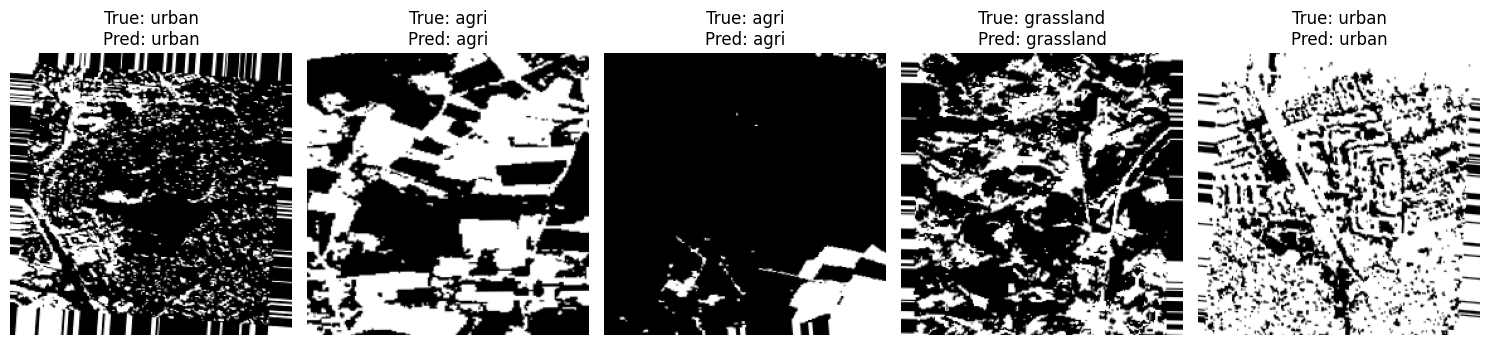

In [9]:

# Plot the images with actual and predicted labels
plt.figure(figsize=(15, 8))
for i, img in enumerate(sample_images):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(array_to_img(img))
    plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()